In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, Dropout, BatchNorm2d, ReLU, Module
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import os

In [2]:
data_path = "../../DATASETS/classification_datasets/cats_and_dogs/train"
device=torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
epochs=50
learning_rate=3e-4
batch_size = 16
num_classes=2

In [3]:
image_list = os.listdir(data_path)
print(f'Number of images in the dataset: {len(image_list)}')
classes = ["cat", "dog"]

Number of images in the dataset: 25000


In [4]:
class CatsAndDogs(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):
       super(CatsAndDogs).__init__()
       self.data_path=data_path
       self.transform = transform
       self.target_transform = target_transform
       images_list = os.listdir(data_path)

    def __len__(self):
        return len(image_list)
    
    def __getitem__(self, idx):
        image_name = image_list[idx]
        image_path = os.path.join(data_path, image_name)
        image = Image.open(image_path)
        if image_name.startswith("cat"):
            label = 0
        else:
            label = 1
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [5]:
my_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()])

In [6]:
my_dataset = CatsAndDogs(data_path=data_path, transform=my_transforms)
train_set = int(0.8*len(my_dataset))
test_set = len(my_dataset) - train_set

train_data, test_data = torch.utils.data.random_split(my_dataset, [train_set, test_set])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
images, labels = next(iter(train_loader))
image = images[0].permute(1, 2, 0)
label = labels[0]

In [8]:
print(images.shape)
print(labels.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        self.block = nn.Sequential(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride=stride, padding = padding),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU())
    def forward(self, x):
        return self.block(x)

In [10]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_maxpool):
        super(InceptionBlock, self).__init__()
        self.in_channels= in_channels
        self.out_1x1 = out_1x1
        self.red_3x3 = red_3x3
        self.out_3x3 = out_3x3
        self.red_5x5 = red_5x5
        self.out_5x5 = out_5x5
        self.out_maxpool = out_maxpool

        self.branch_1x1 = ConvBlock(in_channels = in_channels, out_channels = out_1x1, kernel_size = 1, stride=1, padding=0)
        self.branch_3x3 = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels = red_3x3, kernel_size=1, stride=1, padding=0),
            ConvBlock(in_channels = red_3x3, out_channels = out_3x3, kernel_size = 3, stride=1, padding=1)) 
        self.branch_5x5 = nn.Sequential(
            ConvBlock(in_channels = in_channels, out_channels = red_5x5, kernel_size = 1, stride=1, padding=0),
            ConvBlock(in_channels = red_5x5, out_channels = out_5x5, kernel_size = 5, stride=1, padding=2))
        self.branch_maxpool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels = in_channels, out_channels=out_maxpool, kernel_size=1, stride=1, padding=0))
    def forward(self, x):
        concat = torch.cat([self.branch_1x1(x), self.branch_3x3(x), self.branch_5x5(x), self.branch_maxpool(x)], dim=1)
        return concat


In [11]:
class InceptionV1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionV1, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Stem Block
        self.conv1 = ConvBlock(in_channels = in_channels, out_channels=64, kernel_size = 7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            ConvBlock(in_channels = 64, out_channels = 64, kernel_size=1, stride=1, padding=0),
            ConvBlock(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Block 3
        self.inception3a = InceptionBlock(in_channels=192, out_1x1=64, red_3x3 = 96, out_3x3 = 128, red_5x5 = 16, out_5x5 = 32, out_maxpool = 32)
        self.inception3b = InceptionBlock(in_channels=256, out_1x1=128, red_3x3 = 128, out_3x3 = 192, red_5x5 = 32, out_5x5 = 96, out_maxpool = 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Block 4
        self.inception4a =  InceptionBlock(480, 192, 96, 208, 16, 48, 64)

        # Auxilary 4a
        self.aux4a_conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            ConvBlock(512, 128, 1, 1, 0))

        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)

            # Auxilary 4d
        self.aux4d_conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            ConvBlock(528, 128, 1, 1, 0))

        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Block 5

        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        # Classifiers
            # Auxilary 4a classifier
        self.aux4a_classifier = nn.Sequential(
            nn.Linear(in_features=4*4*128, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(in_features=1024, out_features=num_classes))

        # Auxilary 4d classifier
        self.aux4d_classifier = nn.Sequential(
            nn.Linear(in_features=4*4*128, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(in_features=1024, out_features=num_classes))

            # Main Classifier
        self.main_avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.main_dropout = nn.Dropout(p=0.4)
        self.main_fc = nn.Linear(in_features=1024, out_features=num_classes)
    
    def forward(self,x):
        conv1 = self.conv1(x)
        maxpool1 = self.maxpool1(conv1)
        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        inception3a = self.inception3a(maxpool2)
        inception3b = self.inception3b(inception3a)
        maxpool3 = self.maxpool3(inception3b)

        inception4a = self.inception4a(maxpool3)
        # Inception 4a auxilary classifier
        aux4a_conv = self.aux4a_conv(inception4a)
        aux4a_conv_flattened = torch.flatten(aux4a_conv, start_dim = 1)
        aux4a_classifier = self.aux4a_classifier(aux4a_conv_flattened)

        inception4b = self.inception4b(inception4a)
        inception4c = self.inception4c(inception4b)
        inception4d = self.inception4d(inception4c)
        # Inception 4d auxilary classifier
        aux4d_conv = self.aux4d_conv(inception4d)
        aux4d_conv_flattened = torch.flatten(aux4d_conv, start_dim=1)
        aux4d_classifier = self.aux4d_classifier(aux4d_conv_flattened)

        inception4e = self.inception4e(inception4d)
        maxpool4 = self.maxpool4(inception4e)

        inception5a = self.inception5a(maxpool4)
        inception5b = self.inception5b(inception5a)

        # Inception Main Classifier
        main_avgpool = self.main_avgpool(inception5b)
        main_avgpool_flattened = torch.flatten(main_avgpool, start_dim=1)
        main_dropout = self.main_dropout(main_avgpool_flattened)
        FINAL_OUTPUT = self.main_fc(main_dropout)

        return FINAL_OUTPUT, aux4a_classifier, aux4d_classifier


In [12]:
criterion_main = nn.CrossEntropyLoss()
criterion_ax1 = nn.CrossEntropyLoss()
criterion_ax2 = nn.CrossEntropyLoss()
model = InceptionV1(3, num_classes)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [13]:
def trainEpoch(device, model, loader, optimizer, criterion_main, criterion_ax1, criterion_ax2):
    loop = tqdm(loader)
    model.train()
    
    losses = []
    correct = 0
    total = 0
    
    for batch_id, (images, labels) in enumerate(loop):
        images, labels=images.to(device), labels.to(device)
        model = model.to(device)
        
        main_output, ax1_output, ax2_output = model(images)
        
        _, predicted = torch.max(main_output, 1)
        total += labels.size(0)
        batch_correct = (predicted==labels).sum().item()
        batch_acc = 100*batch_correct/labels.size(0)
        correct += batch_correct
        
        main_loss = criterion_main(main_output, labels)
        ax1_loss = criterion_ax1(ax1_output, labels)
        ax2_loss = criterion_ax2(ax2_output, labels)
        total_loss = 0.4 * main_loss + 0.3 * (ax1_loss + ax2_loss)
        losses.append(total_loss.item())
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        loop.set_postfix(train_loss = total_loss.item(), train_accuracy = batch_acc)
        
    return np.mean(losses), 100*correct/total

def testEpoch(device, model, loader, main_criterion, ax1_criterion, ax2_criterion):
    model.eval()
    with torch.no_grad():
        losses = []
        correct = 0
        total = 0
        
        loop = tqdm(loader)
        for batch_id, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)
            model = model.to(device)
            
            main_output, ax1_output, ax2_output = model(images)
            
            _, predicted = torch.max(main_output, 1)
            total += labels.size(0)
            batch_correct = (predicted==labels).sum().item()
            batch_acc = 100*batch_correct/labels.size(0)
            correct += batch_correct
            
            main_loss = criterion_main(main_output, labels)
            ax1_loss = criterion_ax1(ax1_output, labels)
            ax2_loss = criterion_ax2(ax2_output, labels)
            total_loss = 0.4 * main_loss + 0.3 * (ax1_loss + ax2_loss)
            losses.append(total_loss.item())
            loop.set_postfix(test_loss = total_loss.item(), test_accuracy = batch_acc)

        return np.mean(losses), 100*correct/total

In [14]:
last_best = 0
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range (epochs):
    
    train_loss, train_accuracy = trainEpoch(device, model, train_loader, optimizer, criterion_main, criterion_ax1, criterion_ax2)
    test_loss, test_accuracy = testEpoch(device, model, test_loader, criterion_main, criterion_ax1, criterion_ax2)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    # scheduler.step()

    if last_best <= test_accuracy:
        torch.save(model.state_dict(), 'inceptionv1_cats_and_dogs.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print(f"Epoch-{epoch+1} Train Loss: {train_losses[-1]:.4f} Train Accuracy: {train_acc[-1]:.4f}")
    print(f"Epoch-{epoch+1} Test Loss: {test_losses[-1]:.4f} Test Accuracy: {test_acc[-1]:.4f}")

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('loss_and_acc_inceptionv1.csv')

100%|██████████| 313/313 [00:14<00:00, 21.63it/s, test_accuracy=37.5, test_loss=0.849]


Saving new Best Model!
Epoch-1 Train Loss: 0.5673 Train Accuracy: 70.7850
Epoch-1 Test Loss: 0.5141 Test Accuracy: 73.1800


100%|██████████| 313/313 [00:13<00:00, 23.87it/s, test_accuracy=100, test_loss=0.19]  


Saving new Best Model!
Epoch-2 Train Loss: 0.4268 Train Accuracy: 80.6750
Epoch-2 Test Loss: 0.4964 Test Accuracy: 77.1000


100%|██████████| 313/313 [00:12<00:00, 24.63it/s, test_accuracy=100, test_loss=0.411] 


Saving new Best Model!
Epoch-3 Train Loss: 0.3467 Train Accuracy: 84.7700
Epoch-3 Test Loss: 0.3303 Test Accuracy: 84.5200


100%|██████████| 313/313 [00:13<00:00, 22.98it/s, test_accuracy=75, test_loss=0.613]   


Saving new Best Model!
Epoch-4 Train Loss: 0.2955 Train Accuracy: 87.5300
Epoch-4 Test Loss: 0.2810 Test Accuracy: 88.0400


100%|██████████| 313/313 [00:13<00:00, 23.03it/s, test_accuracy=87.5, test_loss=0.286]


Epoch-5 Train Loss: 0.2684 Train Accuracy: 88.6600
Epoch-5 Test Loss: 0.2797 Test Accuracy: 86.8800


100%|██████████| 313/313 [00:13<00:00, 23.57it/s, test_accuracy=62.5, test_loss=0.702] 


Saving new Best Model!
Epoch-6 Train Loss: 0.2379 Train Accuracy: 89.9000
Epoch-6 Test Loss: 0.2514 Test Accuracy: 89.6000


100%|██████████| 313/313 [00:13<00:00, 23.87it/s, test_accuracy=75, test_loss=0.689]   


Saving new Best Model!
Epoch-7 Train Loss: 0.2249 Train Accuracy: 90.8400
Epoch-7 Test Loss: 0.1981 Test Accuracy: 92.3000


100%|██████████| 313/313 [00:13<00:00, 23.05it/s, test_accuracy=87.5, test_loss=0.333] 


Epoch-8 Train Loss: 0.2087 Train Accuracy: 91.5600
Epoch-8 Test Loss: 0.2079 Test Accuracy: 90.9400


100%|██████████| 313/313 [00:13<00:00, 22.40it/s, test_accuracy=100, test_loss=0.17]   


Epoch-9 Train Loss: 0.1925 Train Accuracy: 92.1250
Epoch-9 Test Loss: 0.2839 Test Accuracy: 86.7000


100%|██████████| 313/313 [00:13<00:00, 24.02it/s, test_accuracy=100, test_loss=0.0041] 


Epoch-10 Train Loss: 0.1866 Train Accuracy: 92.4600
Epoch-10 Test Loss: 0.3246 Test Accuracy: 86.4600


100%|██████████| 313/313 [00:14<00:00, 22.14it/s, test_accuracy=100, test_loss=0.0631] 


Epoch-11 Train Loss: 0.1731 Train Accuracy: 92.9350
Epoch-11 Test Loss: 0.2063 Test Accuracy: 90.9000


100%|██████████| 313/313 [00:13<00:00, 22.38it/s, test_accuracy=87.5, test_loss=0.281] 


Saving new Best Model!
Epoch-12 Train Loss: 0.1686 Train Accuracy: 93.2300
Epoch-12 Test Loss: 0.1803 Test Accuracy: 92.8800


100%|██████████| 313/313 [00:13<00:00, 22.76it/s, test_accuracy=100, test_loss=0.117]  


Epoch-13 Train Loss: 0.1672 Train Accuracy: 93.2050
Epoch-13 Test Loss: 0.2152 Test Accuracy: 90.4800


100%|██████████| 313/313 [00:13<00:00, 23.25it/s, test_accuracy=100, test_loss=0.107]  


Saving new Best Model!
Epoch-14 Train Loss: 0.1515 Train Accuracy: 93.9450
Epoch-14 Test Loss: 0.1646 Test Accuracy: 93.3600


100%|██████████| 313/313 [00:13<00:00, 22.61it/s, test_accuracy=100, test_loss=0.133]  


Epoch-15 Train Loss: 0.1469 Train Accuracy: 94.4100
Epoch-15 Test Loss: 0.2102 Test Accuracy: 91.1000


100%|██████████| 313/313 [00:14<00:00, 22.28it/s, test_accuracy=100, test_loss=0.0561] 


Epoch-16 Train Loss: 0.1435 Train Accuracy: 94.1450
Epoch-16 Test Loss: 0.1742 Test Accuracy: 93.2800


100%|██████████| 313/313 [00:13<00:00, 23.33it/s, test_accuracy=100, test_loss=0.0325] 


Epoch-17 Train Loss: 0.1384 Train Accuracy: 94.6600
Epoch-17 Test Loss: 0.1846 Test Accuracy: 92.3200


100%|██████████| 313/313 [00:13<00:00, 22.92it/s, test_accuracy=100, test_loss=0.107]  


Saving new Best Model!
Epoch-18 Train Loss: 0.1302 Train Accuracy: 94.9150
Epoch-18 Test Loss: 0.1544 Test Accuracy: 93.4000


100%|██████████| 313/313 [00:13<00:00, 22.56it/s, test_accuracy=100, test_loss=0.0593] 


Epoch-19 Train Loss: 0.1296 Train Accuracy: 94.8900
Epoch-19 Test Loss: 0.1879 Test Accuracy: 92.9000


100%|██████████| 313/313 [00:13<00:00, 23.89it/s, test_accuracy=100, test_loss=0.0466] 


Saving new Best Model!
Epoch-20 Train Loss: 0.1244 Train Accuracy: 95.1650
Epoch-20 Test Loss: 0.1322 Test Accuracy: 94.4800


100%|██████████| 313/313 [00:13<00:00, 23.37it/s, test_accuracy=62.5, test_loss=0.863] 


Epoch-21 Train Loss: 0.1217 Train Accuracy: 95.3300
Epoch-21 Test Loss: 0.1421 Test Accuracy: 94.4000


100%|██████████| 313/313 [00:12<00:00, 24.16it/s, test_accuracy=75, test_loss=1.17]     


Saving new Best Model!
Epoch-22 Train Loss: 0.1184 Train Accuracy: 95.3700
Epoch-22 Test Loss: 0.1344 Test Accuracy: 94.7000


100%|██████████| 313/313 [00:12<00:00, 25.53it/s, test_accuracy=87.5, test_loss=0.138] 


Epoch-23 Train Loss: 0.1170 Train Accuracy: 95.4250
Epoch-23 Test Loss: 0.1617 Test Accuracy: 93.7400


100%|██████████| 313/313 [00:12<00:00, 25.66it/s, test_accuracy=100, test_loss=0.0213] 


Epoch-24 Train Loss: 0.1121 Train Accuracy: 95.6350
Epoch-24 Test Loss: 0.1413 Test Accuracy: 94.5600


100%|██████████| 313/313 [00:11<00:00, 26.39it/s, test_accuracy=87.5, test_loss=0.399] 


Epoch-25 Train Loss: 0.1074 Train Accuracy: 95.8550
Epoch-25 Test Loss: 0.1385 Test Accuracy: 94.3800


100%|██████████| 313/313 [00:13<00:00, 23.41it/s, test_accuracy=100, test_loss=0.0486] 


Epoch-26 Train Loss: 0.1026 Train Accuracy: 96.0850
Epoch-26 Test Loss: 0.1737 Test Accuracy: 92.9200


100%|██████████| 313/313 [00:12<00:00, 25.93it/s, test_accuracy=100, test_loss=0.00688]


Saving new Best Model!
Epoch-27 Train Loss: 0.1059 Train Accuracy: 95.9950
Epoch-27 Test Loss: 0.1237 Test Accuracy: 95.0600


100%|██████████| 313/313 [00:12<00:00, 24.93it/s, test_accuracy=100, test_loss=0.0771] 


Epoch-28 Train Loss: 0.0953 Train Accuracy: 96.2000
Epoch-28 Test Loss: 0.1420 Test Accuracy: 94.5000


100%|██████████| 313/313 [00:13<00:00, 23.61it/s, test_accuracy=100, test_loss=0.00366]


Saving new Best Model!
Epoch-29 Train Loss: 0.1022 Train Accuracy: 96.0400
Epoch-29 Test Loss: 0.1213 Test Accuracy: 95.1000


100%|██████████| 313/313 [00:12<00:00, 25.01it/s, test_accuracy=75, test_loss=0.57]     


Epoch-30 Train Loss: 0.0967 Train Accuracy: 96.3950
Epoch-30 Test Loss: 0.1588 Test Accuracy: 94.2200


100%|██████████| 313/313 [00:12<00:00, 24.15it/s, test_accuracy=87.5, test_loss=0.11]   


Epoch-31 Train Loss: 0.0960 Train Accuracy: 96.2650
Epoch-31 Test Loss: 0.1614 Test Accuracy: 94.0800


100%|██████████| 313/313 [00:12<00:00, 24.85it/s, test_accuracy=87.5, test_loss=0.223] 


Epoch-32 Train Loss: 0.0941 Train Accuracy: 96.5650
Epoch-32 Test Loss: 0.1613 Test Accuracy: 94.2400


100%|██████████| 313/313 [00:12<00:00, 24.74it/s, test_accuracy=87.5, test_loss=0.284] 


Epoch-33 Train Loss: 0.0881 Train Accuracy: 96.7750
Epoch-33 Test Loss: 0.1424 Test Accuracy: 94.1800


100%|██████████| 313/313 [00:11<00:00, 26.72it/s, test_accuracy=100, test_loss=0.14]   


Epoch-34 Train Loss: 0.0950 Train Accuracy: 96.5050
Epoch-34 Test Loss: 0.1680 Test Accuracy: 93.5800


100%|██████████| 313/313 [00:12<00:00, 25.95it/s, test_accuracy=87.5, test_loss=0.266] 


Epoch-35 Train Loss: 0.0839 Train Accuracy: 96.7900
Epoch-35 Test Loss: 0.1415 Test Accuracy: 94.5600


100%|██████████| 313/313 [00:11<00:00, 26.67it/s, test_accuracy=100, test_loss=0.0215] 


Saving new Best Model!
Epoch-36 Train Loss: 0.0807 Train Accuracy: 97.0500
Epoch-36 Test Loss: 0.1242 Test Accuracy: 95.1800


100%|██████████| 313/313 [00:12<00:00, 25.12it/s, test_accuracy=100, test_loss=0.0595]  


Saving new Best Model!
Epoch-37 Train Loss: 0.0827 Train Accuracy: 96.8850
Epoch-37 Test Loss: 0.1196 Test Accuracy: 95.3800


100%|██████████| 313/313 [00:12<00:00, 25.17it/s, test_accuracy=100, test_loss=0.00915]


Epoch-38 Train Loss: 0.0807 Train Accuracy: 96.9150
Epoch-38 Test Loss: 0.1306 Test Accuracy: 94.9800


100%|██████████| 313/313 [00:12<00:00, 25.71it/s, test_accuracy=100, test_loss=0.0261] 


Epoch-39 Train Loss: 0.0836 Train Accuracy: 96.9450
Epoch-39 Test Loss: 0.1518 Test Accuracy: 94.0800


100%|██████████| 313/313 [00:13<00:00, 23.23it/s, test_accuracy=100, test_loss=0.0215]  


Epoch-40 Train Loss: 0.0776 Train Accuracy: 97.0750
Epoch-40 Test Loss: 0.1257 Test Accuracy: 95.2800


100%|██████████| 313/313 [00:12<00:00, 25.32it/s, test_accuracy=100, test_loss=0.0139]  


Epoch-41 Train Loss: 0.0767 Train Accuracy: 97.1650
Epoch-41 Test Loss: 0.1253 Test Accuracy: 95.3400


100%|██████████| 313/313 [00:13<00:00, 24.01it/s, test_accuracy=100, test_loss=0.072]  


Saving new Best Model!
Epoch-42 Train Loss: 0.0800 Train Accuracy: 97.0600
Epoch-42 Test Loss: 0.1121 Test Accuracy: 95.8400


100%|██████████| 313/313 [00:12<00:00, 25.02it/s, test_accuracy=100, test_loss=0.0246] 


Epoch-43 Train Loss: 0.0738 Train Accuracy: 97.2150
Epoch-43 Test Loss: 0.1474 Test Accuracy: 94.2800


100%|██████████| 313/313 [00:12<00:00, 25.48it/s, test_accuracy=75, test_loss=0.637]    


Epoch-44 Train Loss: 0.0734 Train Accuracy: 97.2400
Epoch-44 Test Loss: 0.1234 Test Accuracy: 94.9000


100%|██████████| 313/313 [00:12<00:00, 25.54it/s, test_accuracy=100, test_loss=0.0229]  


Epoch-45 Train Loss: 0.0728 Train Accuracy: 97.3700
Epoch-45 Test Loss: 0.1308 Test Accuracy: 95.4000


100%|██████████| 313/313 [00:12<00:00, 24.58it/s, test_accuracy=100, test_loss=0.0912]  


Epoch-46 Train Loss: 0.0640 Train Accuracy: 97.6500
Epoch-46 Test Loss: 0.1546 Test Accuracy: 94.6600


100%|██████████| 313/313 [00:11<00:00, 26.74it/s, test_accuracy=100, test_loss=0.0599]  


Epoch-47 Train Loss: 0.0689 Train Accuracy: 97.4450
Epoch-47 Test Loss: 0.1161 Test Accuracy: 95.7200


100%|██████████| 313/313 [00:12<00:00, 24.88it/s, test_accuracy=87.5, test_loss=0.153]  


Epoch-48 Train Loss: 0.0665 Train Accuracy: 97.5100
Epoch-48 Test Loss: 0.1166 Test Accuracy: 95.5000


100%|██████████| 313/313 [00:12<00:00, 25.87it/s, test_accuracy=100, test_loss=0.0123]  


Epoch-49 Train Loss: 0.0647 Train Accuracy: 97.6800
Epoch-49 Test Loss: 0.1635 Test Accuracy: 94.1600


100%|██████████| 313/313 [00:11<00:00, 27.00it/s, test_accuracy=100, test_loss=0.0118]  


Saving new Best Model!
Epoch-50 Train Loss: 0.0672 Train Accuracy: 97.5600
Epoch-50 Test Loss: 0.1144 Test Accuracy: 95.8400


In [15]:
train_loss = df["train_loss"]
train_acc = df["train_accuracy"]
valid_loss = df["test_loss"]
valid_acc = df["test_accuracy"]

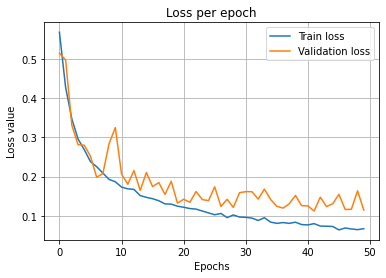

In [16]:
plt.plot(train_loss, label="Train loss")
plt.plot(valid_loss, label="Validation loss")
plt.title("Loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.grid()
plt.show()

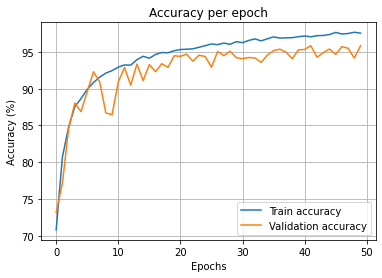

In [17]:
plt.plot(train_acc, label="Train accuracy")
plt.plot(valid_acc, label="Validation accuracy")
plt.title("Accuracy per epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

In [18]:
# Now, let's load the trained model
model = InceptionV1(3, num_classes)
model.load_state_dict(torch.load("inceptionv1_cats_and_dogs.pt"))

<All keys matched successfully>

In [26]:
correct = 0
total = 0
model = model.to(device)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in tqdm(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
       
        
        # calculate outputs by running images through the network
        main_output, x, y = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(main_output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

100%|██████████| 313/313 [00:10<00:00, 30.40it/s]

Accuracy of the network on the test images: 96 %


In [27]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model=model.to(device)
        main_output, x, y = model(images)
        _, predictions = torch.max(main_output, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

100%|██████████| 313/313 [00:10<00:00, 28.79it/s]

Accuracy for class: cat   is 95.6 %
Accuracy for class: dog   is 96.5 %


In [28]:
def show_images(images, true_labels, predicted_labels, nrows, ncols, classes):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        # Convert the tensor image to a NumPy array
        img = images[i]
        img = transforms.ToPILImage()(img)
        true_label = classes[true_labels[i]]
        predicted_label = classes[predicted_labels[i]]

        # Display the image
        ax.imshow(img)

        # Display the label below the image
        if true_label == predicted_label:
            font_color  = "green"
        else:
            font_color = "red"
        ax.set_xlabel(f"GT: {true_label} | Predicted: {predicted_label}", color=font_color)

        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_facecolor("white")

    plt.tight_layout()
    plt.show()

In [29]:
images, true_labels = next(iter(test_loader))
images = images.to(device)
model = model.to(device)
main_output, x, y = model(images)
_, predicted_labels = torch.max(main_output.data, 1)
true_labels = true_labels.numpy()
predicted_labels = predicted_labels.cpu().detach().numpy()

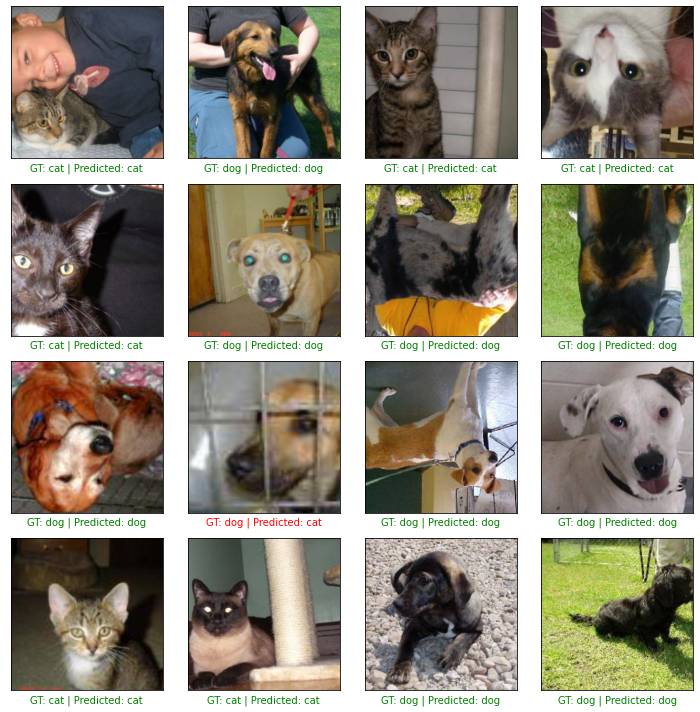

In [30]:
show_images(images, true_labels, predicted_labels, 4,4, classes)